## 1. Data Collection (Web Scraping)

In [1]:
import re
import json
import time
import html
from pathlib import Path
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
BASE = "https://www.ulta.com"
CAT  = "https://www.ulta.com/shop/fragrance/womens-fragrance"

TARGET_N = 500
MAX_PAGES = 30
SLEEP_PAGES = 1.5
SLEEP_PRODUCTS = 1.5

OUT_DIR = Path.home() / "ulta_womens_fragrance"
OUT_DIR.mkdir(parents=True, exist_ok=True)

URLS_JSON = OUT_DIR / "product_urls_450.json"
CSV_PATH  = OUT_DIR / "ulta_womens_fragrance_450.csv"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

In [3]:
def get_html(url: str) -> str:
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    r.encoding = r.apparent_encoding
    return r.text

def clean_text(t: str | None) -> str | None:
    if not t:
        return None
    t = html.unescape(t).replace("\xa0", " ").replace("Â", "")
    t = re.sub(r"\s+", " ", t).strip()
    return t

def normalize_product_url(href: str | None) -> str | None:
    if not href:
        return None
    full = href if href.startswith("http") else urljoin(BASE, href)
    full = full.split("?")[0]
    if any(k in full for k in ["/p/", "pimprod", "/product/"]):
        return full
    return None

def parse_json_ld(soup: BeautifulSoup) -> list[dict]:
    out = []
    for tag in soup.select('script[type="application/ld+json"]'):
        raw = (tag.string or "").strip()
        if not raw:
            continue
        try:
            data = json.loads(raw)
            if isinstance(data, list):
                out.extend([x for x in data if isinstance(x, dict)])
            elif isinstance(data, dict):
                out.append(data)
        except Exception:
            pass
    return out

def find_product_json(jsonlds: list[dict]) -> dict | None:
    for obj in jsonlds:
        if obj.get("@type") == "Product":
            return obj
    for obj in jsonlds:
        if "@graph" in obj:
            for g in obj.get("@graph", []):
                if isinstance(g, dict) and g.get("@type") == "Product":
                    return g
    return None

def offers_to_prices(offers) -> list[float]:
    prices = []
    if isinstance(offers, dict):
        offers = [offers]
    if not isinstance(offers, list):
        return prices

    for off in offers:
        if not isinstance(off, dict):
            continue
        p = off.get("price")
        if p is None:
            continue
        try:
            prices.append(float(str(p).replace("$", "").strip()))
        except Exception:
            pass
    return prices

In [4]:
def collect_product_urls(target_n: int = TARGET_N, max_pages: int = MAX_PAGES) -> list[str]:
    urls = set()

    for page in range(1, max_pages + 1):
        page_url = f"{CAT}?page={page}"
        s = BeautifulSoup(get_html(page_url), "html.parser")

        page_links = set()
        for a in s.select("a[href]"):
            u = normalize_product_url(a.get("href"))
            if u:
                page_links.add(u)

        before = len(urls)
        urls |= page_links
        added = len(urls) - before

        print(f"[collect] page={page:02d} found={len(page_links)} added={added} total={len(urls)}")

        if len(urls) >= target_n:
            break

        if added == 0 and page >= 3:
            break

        time.sleep(SLEEP_PAGES)

    urls = sorted(urls)[:target_n]
    URLS_JSON.write_text(json.dumps(urls, indent=2), encoding="utf-8")
    return urls

In [6]:
def scrape_product(url: str) -> dict:
    s = BeautifulSoup(get_html(url), "html.parser")

    jsonlds = parse_json_ld(s)
    prod = find_product_json(jsonlds)

    name = None
    desc = None
    price = None
    rating = None
    rating_count = None

    if prod:
        name = clean_text(prod.get("name"))
        desc = clean_text(prod.get("description"))

        prices = offers_to_prices(prod.get("offers"))
        price = max(prices) if prices else None

        agg = prod.get("aggregateRating")
        if isinstance(agg, dict):
            try:
                rating = float(agg.get("ratingValue")) if agg.get("ratingValue") is not None else None
            except Exception:
                rating = None
            rc = agg.get("reviewCount") or agg.get("ratingCount")
            try:
                rating_count = int(float(rc)) if rc is not None else None
            except Exception:
                rating_count = None

    if not name:
        h1 = s.select_one("h1")
        name = clean_text(h1.get_text(" ", strip=True)) if h1 else None

    if price is None:
        meta_price = s.select_one('meta[property="product:price:amount"]')
        if meta_price and meta_price.get("content"):
            try:
                price = float(meta_price["content"])
            except Exception:
                pass

    if not desc:
        meta_desc = s.select_one('meta[name="description"]')
        if meta_desc and meta_desc.get("content"):
            desc = clean_text(meta_desc["content"])

    return {
        "url": url,
        "product_name": name,
        "product_price": price,
        "product_rating": rating,
        "rating_count": rating_count,
        "product_description": desc,
    }

## 2. Data Preparation

In [7]:
def scrape_all(urls: list[str]) -> pd.DataFrame:
    rows = []
    for i, url in enumerate(urls, 1):
        print(f"[scrape] {i}/{len(urls)} {url}")
        try:
            rows.append(scrape_product(url))
        except Exception as e:
            rows.append({
                "url": url,
                "product_name": None,
                "product_price": None,
                "product_rating": None,
                "rating_count": None,
                "product_description": None,
                "error": str(e),
            })
        time.sleep(SLEEP_PRODUCTS)

    df = pd.DataFrame(rows)

    if "product_price" in df.columns:
        df["product_price"] = pd.to_numeric(df["product_price"], errors="coerce")
    if "product_rating" in df.columns:
        df["product_rating"] = pd.to_numeric(df["product_rating"], errors="coerce")
    if "rating_count" in df.columns:
        df["rating_count"] = pd.to_numeric(df["rating_count"], errors="coerce")

    df.to_csv(CSV_PATH, index=False)
    print(f"Saved: {CSV_PATH} | rows={df.shape[0]}")
    return df

if URLS_JSON.exists():
    urls = json.loads(URLS_JSON.read_text(encoding="utf-8"))
    if len(urls) < TARGET_N:
        urls = collect_product_urls()
else:
    urls = collect_product_urls()

df = scrape_all(urls)
df.head()

[scrape] 1/500 https://www.ulta.com/p/000-eau-de-parfum-pimprod2055382
[scrape] 2/500 https://www.ulta.com/p/11-11-azure-eau-de-parfum-pimprod2042863
[scrape] 3/500 https://www.ulta.com/p/11-11-eau-de-parfum-pimprod2009910
[scrape] 4/500 https://www.ulta.com/p/11-11-lychee-eau-de-parfum-pimprod2053422
[scrape] 5/500 https://www.ulta.com/p/11-11-moon-eau-de-parfum-pimprod2056967
[scrape] 6/500 https://www.ulta.com/p/11-11-vanilla-eau-de-parfum-pimprod2046657
[scrape] 7/500 https://www.ulta.com/p/1200-eau-de-parfum-pimprod2048705
[scrape] 8/500 https://www.ulta.com/p/222-cosmic-coco-musk-hair-body-mist-pimprod2052191
[scrape] 9/500 https://www.ulta.com/p/3-piece-coffret-set-pimprod2055184
[scrape] 10/500 https://www.ulta.com/p/4-piece-discovery-set-pimprod2050388
[scrape] 11/500 https://www.ulta.com/p/555-strawberry-aire-hair-body-mist-pimprod2052190
[scrape] 12/500 https://www.ulta.com/p/7-summers-eau-de-toilette-pimprod2038419
[scrape] 13/500 https://www.ulta.com/p/acqua-di-gioia-eau-d

,url,product_name,product_price,product_rating,rating_count,product_description,error
0,https://www.ulta.com/p/000-eau-de-parfum-pimpr...,000 Eau De Parfum,28.0,3.7,7.0,Classic and versatile like a fresh white T-Shi...,NaN
1,https://www.ulta.com/p/11-11-azure-eau-de-parf...,11 11 Azure Eau de Parfum - 1.7 oz,105.0,4.4,1286.0,"Blue Skies, Azure Waters. Inspired by the shee...",NaN
2,https://www.ulta.com/p/11-11-eau-de-parfum-pim...,11 11 Eau de Parfum - 1.7 oz,105.0,4.4,1286.0,Lake & Skye's best-selling 11 11 Eau de Parfum...,NaN
3,https://www.ulta.com/p/11-11-lychee-eau-de-par...,11 11 Lychee Eau de Parfum - 1.7 oz,105.0,3.9,27.0,"A burst of optimism wrapped in soft, radiant p...",NaN
4,https://www.ulta.com/p/11-11-moon-eau-de-parfu...,11 11 Moon Eau de Parfum - 1.7 oz,105.0,4.4,211.0,Let it pull you closer. A celestial reimaginin...,NaN


## 3. Sentiment Analysis

/var/folders/1l/r_1yydhs67v0kv8qhmgmnh5w0000gp/T/ipykernel_1867/1263935586.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_group', y='sentiment_score', data=df, palette='Set2')


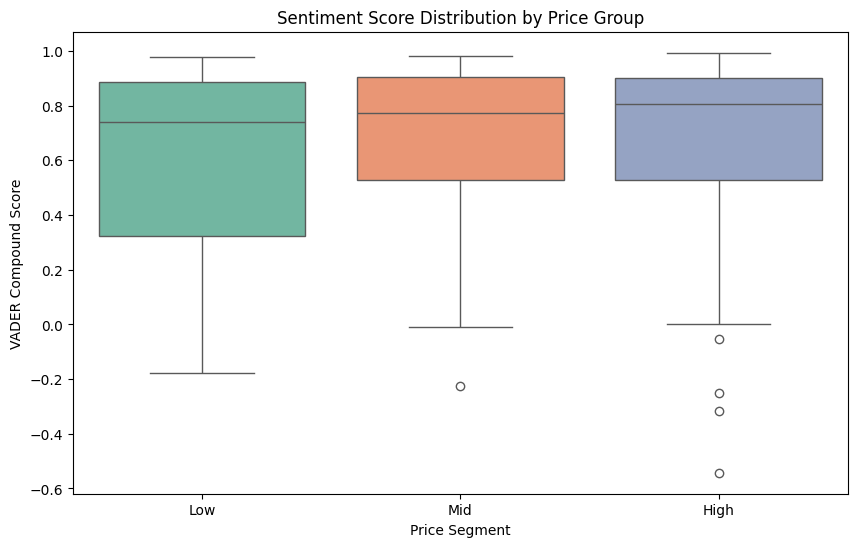

             count      mean       std     min      25%      50%     75%  \
price_group                                                                
Low          174.0  0.590652  0.349532 -0.1779  0.32365  0.73905  0.8860   
Mid          158.0  0.661512  0.306321 -0.2263  0.52670  0.77500  0.9037   
High         167.0  0.679380  0.313907 -0.5423  0.52670  0.80740  0.9003   

                max  
price_group          
Low          0.9783  
Mid          0.9810  
High         0.9937  


/var/folders/1l/r_1yydhs67v0kv8qhmgmnh5w0000gp/T/ipykernel_1867/1263935586.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('price_group')['sentiment_score'].describe())


In [8]:
df['price_group'] = pd.qcut(df['product_price'], 3, labels=['Low', 'Mid', 'High'])

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    if pd.isna(text):
        return 0
    return analyzer.polarity_scores(str(text))['compound']

df['sentiment_score'] = df['product_description'].apply(get_sentiment_score)

plt.figure(figsize=(10, 6))
sns.boxplot(x='price_group', y='sentiment_score', data=df, palette='Set2')
plt.title('Sentiment Score Distribution by Price Group')
plt.xlabel('Price Segment')
plt.ylabel('VADER Compound Score')
plt.show()

print(df.groupby('price_group')['sentiment_score'].describe())

## 4. Keyword Comparison (TF-IDF)

In [9]:
low_group = df[df['price_group'] == 'Low']['product_description'].fillna('')
high_group = df[df['price_group'] == 'High']['product_description'].fillna('')

vectorizer = TfidfVectorizer(stop_words='english', max_features=20)

def get_top_tfidf(corpus):
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return pd.DataFrame({'word': feature_names, 'score': scores}).sort_values(by='score', ascending=False)

low_keywords = get_top_tfidf(low_group)
high_keywords = get_top_tfidf(high_group)

print("=== Low Price Group Top Keywords ===")
print(low_keywords.head(10))
print("\n=== High Price Group Top Keywords ===")
print(high_keywords.head(10))

=== Low Price Group Top Keywords ===
         word      score
4   fragrance  27.119914
12      scent  26.382647
1         eau  24.698270
0        body  24.618008
8        mist  24.461952
7        hair  24.220731
10     parfum  20.321729
18    vanilla  17.719073
15       skin  17.347515
3      floral  16.831155

=== High Price Group Top Keywords ===
         word      score
2         eau  39.212987
11     parfum  35.487936
4   fragrance  33.318520
3      floral  28.960589
19      women  20.243641
12    perfume  18.251937
10      notes  17.886133
14      scent  16.680685
13       rose  16.066710
17    vanilla  15.174272


/var/folders/1l/r_1yydhs67v0kv8qhmgmnh5w0000gp/T/ipykernel_1867/1682019198.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='word', data=low_keywords.head(10), ax=axes[0], palette='Blues_r')
/var/folders/1l/r_1yydhs67v0kv8qhmgmnh5w0000gp/T/ipykernel_1867/1682019198.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='word', data=high_keywords.head(10), ax=axes[1], palette='Reds_r')


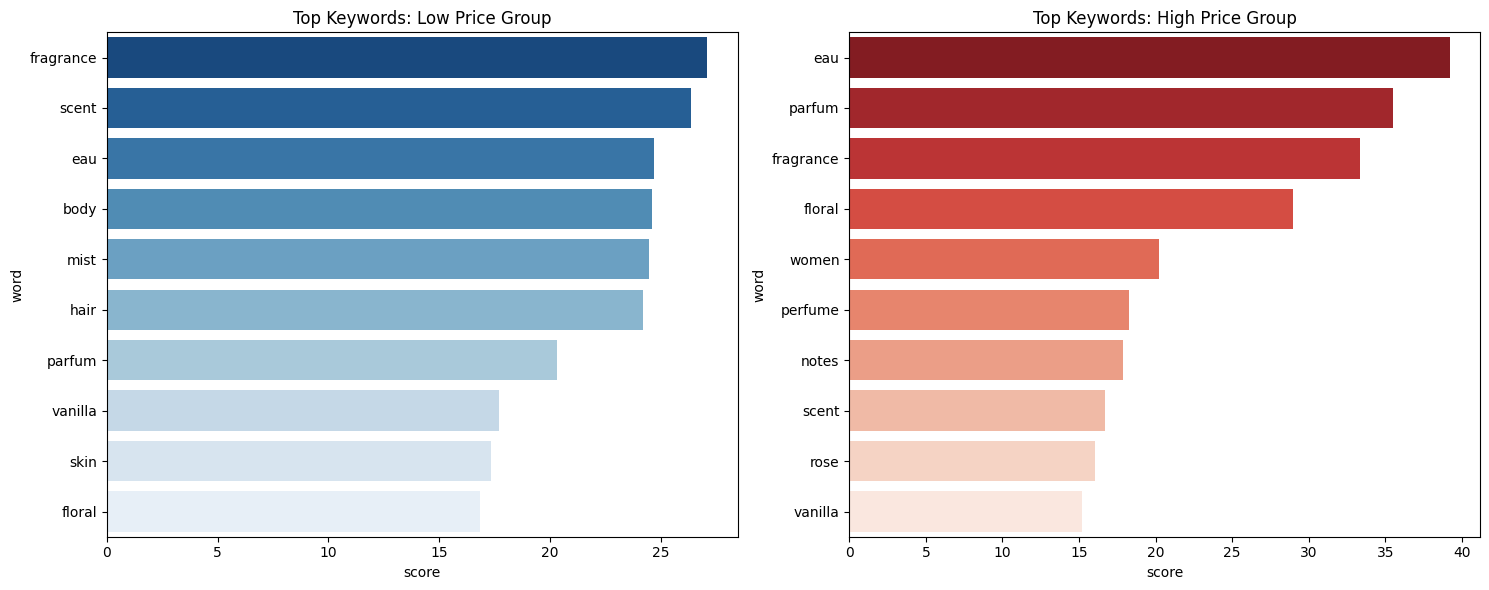

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='score', y='word', data=low_keywords.head(10), ax=axes[0], palette='Blues_r')
axes[0].set_title('Top Keywords: Low Price Group')

sns.barplot(x='score', y='word', data=high_keywords.head(10), ax=axes[1], palette='Reds_r')
axes[1].set_title('Top Keywords: High Price Group')

plt.tight_layout()
plt.show()

## 5. Classification Model

In [13]:
df['product_description'] = df['product_description'].fillna('')
df['word_count'] = df['product_description'].apply(lambda x: len(str(x).split()))

df['is_high_rating'] = (df['product_rating'] >= 4.5).astype(int)

df['brand'] = df['product_name'].fillna('').astype(str).str.split().str[0]

df_ml = df.copy()
df_ml = pd.get_dummies(df_ml, columns=['brand'], drop_first=True)

features = ['product_price', 'sentiment_score', 'word_count']
brand_cols = [c for c in df_ml.columns if c.startswith('brand_')]
X_features = features + brand_cols

df_ml = df_ml.dropna(subset=features + ['is_high_rating'])

X = df_ml[X_features]
y = df_ml['is_high_rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, pred):.4f}")

importance = pd.DataFrame({'feature': X_features, 'importance': model.feature_importances_})
print(importance.sort_values(by='importance', ascending=False).head(10))

Model Accuracy: 0.7000
             feature  importance
0      product_price    0.152205
1    sentiment_score    0.125009
2         word_count    0.122509
4           brand_11    0.021810
142        brand_MOD    0.016587
60       brand_Cloud    0.016274
165        brand_N°5    0.015889
63      brand_Cosmic    0.015256
82      brand_Eilish    0.014844
70     brand_Dearest    0.013512


/var/folders/1l/r_1yydhs67v0kv8qhmgmnh5w0000gp/T/ipykernel_1867/2006010216.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=imp_df, palette='viridis')


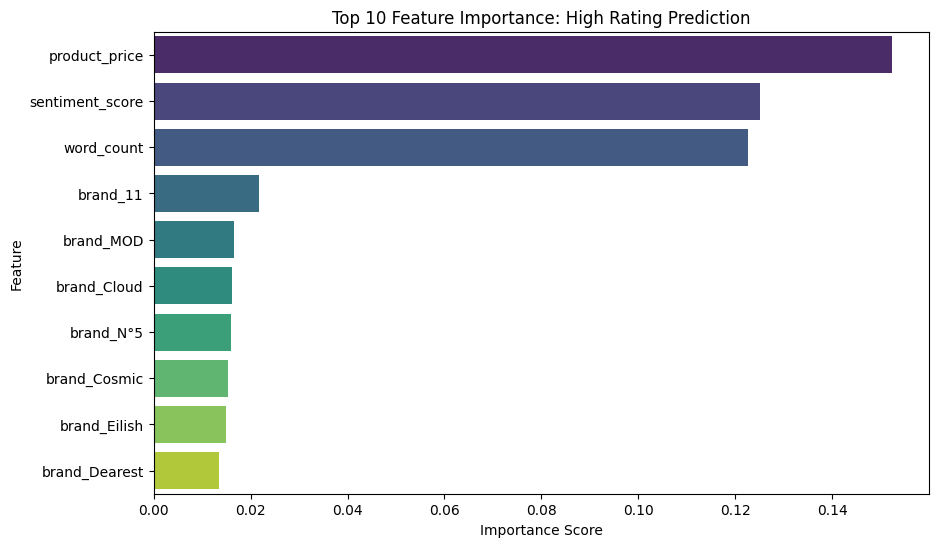

In [14]:
imp_df = pd.DataFrame({
    'feature': X_features,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=imp_df, palette='viridis')
plt.title('Top 10 Feature Importance: High Rating Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

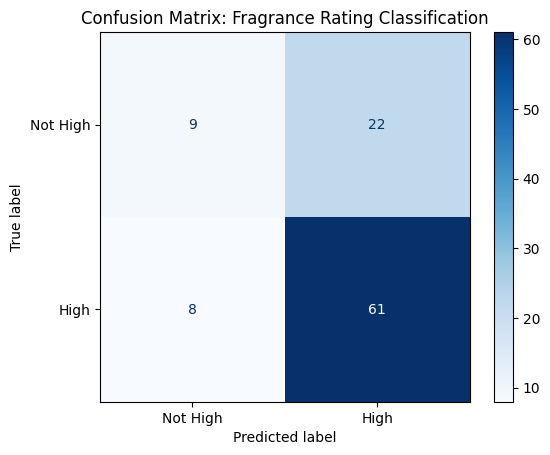

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Fragrance Rating Classification')
plt.show()

## 6. Conclusion

- Higher-priced products show slightly higher sentiment scores.
- Luxury products use terms like "eau" and "parfum".
- Budget products use terms like "body" and "mist".
- Price is the strongest predictor of high ratings.